In [72]:
import numpy as np
import pandas as pd
import pandas_ta as ta
from tiny_ta import atr, rsi, sma

# End of the Month - Strategie im SDAX

Zunächst werden die Kursdaten für den SDAX geladen und bereinigt

In [73]:
sdax = pd.read_csv(
    "sdax.csv",
    decimal=",",
    thousands=".",
    date_format="%d.%m.%Y",
    parse_dates=["Datum"],
).set_index("Datum")

sdax.rename(
    {
        "Zuletzt": "Close",
        "Eröffn.": "Open",
        "Hoch": "High",
        "Tief": "Low",
        "Vol.": "Volume",
    },
    inplace=True,
    axis=1,
)

stock = sdax.sort_index(ascending=True)[["Open", "High", "Low", "Close"]]
stock = stock[~(stock.High == stock.Low) & ~(stock.Open == stock.Close)]
stock = stock.dropna()

Ein paar Indikatoren für spätere Auswertungen

In [74]:
stock["rsi_3"] = rsi(stock.Close, 3)
stock["rsi_7"] = rsi(stock.Close, 7)
stock["rsi_10"] = rsi(stock.Close, 10)

stock["atr_10"] = atr(stock, 10, smoothing="rma") / stock.Close * 100

adx_intervall = 21
adx = ta.adx(stock.High, stock.Low, stock.Close, adx_intervall)
stock["adx"] = adx[f"ADX_{adx_intervall}"]
stock["adx_direction"] = np.where(
    adx[f"DMP_{adx_intervall}"] > adx[f"DMN_{adx_intervall}"], 1, -1
)

stock["adx_10"] = ta.adx(stock.High, stock.Low, stock.Close, 10, 10)["ADX_10"]


stock["sma"] = sma(stock.Close, 20)
stock["sma_20"] = stock.Close / sma(stock.Close, 20)
stock["sma_50"] = stock.Close / sma(stock.Close, 50)
stock["sma_100"] = stock.Close / sma(stock.Close, 100)
stock["sma_200"] = stock.Close / sma(stock.Close, 200)

stock["sma_pct"] = (stock.Close / stock.sma).round(2)

stock["month"] = stock.index.month

Markiere die letzten x Tage und ersten x Tage im Monat für die geplanten Trades. 

In [75]:
days = 5

# Identify end of month
end_of_month = stock.groupby([stock.index.year, stock.index.month]).tail(days)

# Identify beginning of month
beginning_of_month = stock.groupby([stock.index.year, stock.index.month]).head(days)

# add countdown
end_of_month["countdown"] = -1
end_of_month["days"] = end_of_month["countdown"].cumsum().add(1).mod(days)
end_of_month.loc[end_of_month.days == 0, "days"] = days
end_of_month["days"] = end_of_month["days"] * -1

beginning_of_month["countdown"] = 1
beginning_of_month["days"] = beginning_of_month["countdown"].cumsum().mod(days)
beginning_of_month.loc[beginning_of_month.days == 0, "days"] = days

# Combine the results
marked_days = pd.concat([end_of_month, beginning_of_month])
marked_days["hold"] = 1

df = pd.merge(
    left=stock,
    right=marked_days[["hold", "days"]],
    left_index=True,
    right_index=True,
    how="left",
)

df.hold = df.hold.fillna(0)

df["buy"] = np.where(
    (df.hold.shift(1) == 0) & (df.hold == 1),
    1,
    np.where((df.hold == 1) & (df.hold.shift(-1) == 0), -1, np.nan),
)

df.hold = np.where(df.hold == 1, df.Low, np.nan)

## Jetzt zur Strategie
Es wird 5 Tage vor Monatsende gekauft und 5 Tage nach Monatsanfang gekauft

In [76]:
from backtesting import Strategy


class end_of_month(Strategy):
    """
    strategy for trend_trading
    """

    days_before = -5
    days_after = 5

    def ohlc(self, pos=-1) -> tuple:
        """
        helper function for ohlc data
        """
        return (
            self.data.Open[pos],
            self.data.High[pos],
            self.data.Low[pos],
            self.data.Close[pos],
        )

    def init(self):
        super().init()

        self.sma = self.I(lambda: self.data.sma, name="SMA")

        # self.rsi = self.I(lambda: self.data.rsi, name="RSI", overlay=False)
        self.atr_10 = self.I(lambda: self.data.atr_10, name="ATR", overlay=False)

    def next(self):
        # super().next()

        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if self.data.days[-1] == self.days_after:
                    trade.close()

        if self.data.days[-1] == self.days_before:
            self.buy()

In [77]:
from backtesting import Backtest

bt = Backtest(
    df["2012-01-01":], end_of_month, cash=100_000, commission=0.002, trade_on_close=True
)
stats = bt.run()
bt.plot(superimpose=False, open_browser=False)
stats

Start                     2012-01-02 00:00:00
End                       2024-04-15 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   47.349823
Equity Final [$]                 205482.13358
Equity Peak [$]                  207808.37358
Return [%]                         105.482134
Buy & Hold Return [%]              221.032972
Return (Ann.) [%]                    6.003286
Volatility (Ann.) [%]               11.235143
Sharpe Ratio                         0.534331
Sortino Ratio                        0.811563
Calmar Ratio                         0.356454
Max. Drawdown [%]                  -16.841679
Avg. Drawdown [%]                   -2.691227
Max. Drawdown Duration      851 days 00:00:00
Avg. Drawdown Duration       71 days 00:00:00
# Trades                                  148
Win Rate [%]                        62.837838
Best Trade [%]                       8.823031
Worst Trade [%]                     -9.948211
Avg. Trade [%]                    

<Axes: xlabel='EntryTime', ylabel='ReturnPct'>

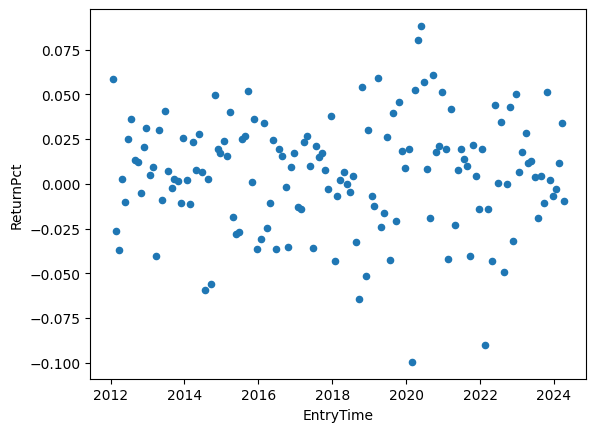

In [78]:
trades = stats["_trades"]
trades.plot.scatter(y="ReturnPct", x="EntryTime")

In [79]:
trades[trades.ReturnPct < -0.05]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
30,17,648,657,7290.00090,6855.94,-7379.03530,-0.059542,2014-07-25,2014-08-07,13 days
32,17,691,700,6868.61982,6483.92,-6539.89694,-0.056008,2014-09-24,2014-10-08,14 days
80,10,1702,1711,12086.10396,11310.22,-7758.83960,-0.064196,2018-09-24,2018-10-08,14 days
82,12,1746,1755,10547.94378,10005.35,-6511.12536,-0.051441,2018-11-26,2018-12-07,11 days
97,11,2056,2065,12274.15932,11053.10,-13431.65252,-0.099482,2020-02-24,2020-03-06,11 days
121,13,2564,2573,14171.99742,12895.09,-16599.79646,-0.090101,2022-02-22,2022-03-07,13 days


Vielleicht wäre ein Stopp doch hilfreich

In [80]:
class end_of_month_with_SL(end_of_month):
    """
    strategy for trend_trading
    """

    skip_month = []

    def next(self):
        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if trade.pl_pct < -0.06:
                    trade.close()

                if self.data.days[-1] == self.days_after:
                    trade.close()

        if (
            self.data.days[-1] == self.days_before
            and self.data.month[-1] not in self.skip_month
        ):
            self.buy()

In [81]:
from backtesting import Backtest

bt = Backtest(
    df["2012-01-01":],
    end_of_month_with_SL,
    cash=100_000,
    commission=0.002,
    trade_on_close=True,
)
stats = bt.run()
bt.plot(superimpose=False, open_browser=False)
stats

Start                     2012-01-02 00:00:00
End                       2024-04-15 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                    47.12496
Equity Final [$]                 205816.36336
Equity Peak [$]                  208142.60336
Return [%]                         105.816363
Buy & Hold Return [%]              221.032972
Return (Ann.) [%]                    6.017233
Volatility (Ann.) [%]               11.174959
Sharpe Ratio                         0.538457
Sortino Ratio                        0.817959
Calmar Ratio                         0.331381
Max. Drawdown [%]                  -18.158061
Avg. Drawdown [%]                   -2.665613
Max. Drawdown Duration      852 days 00:00:00
Avg. Drawdown Duration       72 days 00:00:00
# Trades                                  148
Win Rate [%]                        62.837838
Best Trade [%]                       8.823031
Worst Trade [%]                     -7.685572
Avg. Trade [%]                    

<Axes: xlabel='EntryTime', ylabel='ReturnPct'>

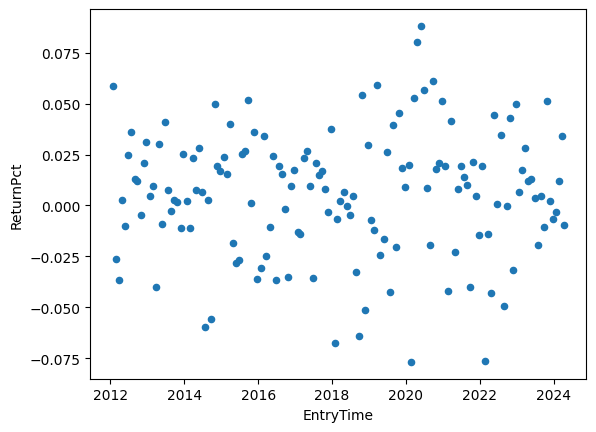

In [82]:
trades = stats["_trades"]
trades.plot.scatter(y="ReturnPct", x="EntryTime")

jetzt wird überprüft welche Tage für die Ein- und Ausstiege besser sein könnten.

In [83]:
stats, heatmap = bt.optimize(
    days_before=range(-5, 0, 1),
    days_after=range(1, 6),
    maximize="Profit Factor",  # "Equity Final [$]",
    max_tries=200,
    random_state=0,
    return_heatmap=True,
)

/Users/produktmanagement/Python/github/backtesting-trading-strategies/.venv/lib/python3.12/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [84]:
# heatmap
heatmap.sort_values().iloc[-3:]

days_before  days_after
-4           1             1.659026
-5           2             1.673895
             1             1.895187
Name: Profit Factor, dtype: float64

In [85]:
heatmap.groupby(["days_before", "days_after"]).mean().unstack()

days_after,1,2,3,4,5
days_before,,,,,
-5,1.895187,1.673895,1.557569,1.483734,1.590476
-4,1.659026,1.524719,1.424600,1.361042,1.411674
-3,1.591975,1.482759,1.380775,1.306044,1.363608
-2,1.563858,1.489131,1.352398,1.297957,1.407011
-1,1.172482,1.169463,1.111881,1.107100,1.207563


In [86]:
stats

Start                     2012-01-02 00:00:00
End                       2024-04-15 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   28.429168
Equity Final [$]                 185873.30742
Equity Peak [$]                  190571.22254
Return [%]                          85.873307
Buy & Hold Return [%]              221.032972
Return (Ann.) [%]                    5.146143
Volatility (Ann.) [%]                7.990857
Sharpe Ratio                         0.644004
Sortino Ratio                        0.966677
Calmar Ratio                          0.48405
Max. Drawdown [%]                  -10.631438
Avg. Drawdown [%]                   -1.960284
Max. Drawdown Duration      581 days 00:00:00
Avg. Drawdown Duration       58 days 00:00:00
# Trades                                  148
Win Rate [%]                        60.135135
Best Trade [%]                       5.141215
Worst Trade [%]                     -7.685572
Avg. Trade [%]                    

## The Winner is ...

In [87]:
stats["_strategy"]

<Strategy end_of_month_with_SL(days_before=-5,days_after=1)>

In [88]:
# bt = Backtest(df["2012-01-01":], end_of_month, cash=100_000, commission=0.002)
stats = bt.run(days_before=-5, days_after=1)
bt.plot(superimpose=False, open_browser=False)

Row(id='12747', ...)

In [89]:
stats

Start                     2012-01-02 00:00:00
End                       2024-04-15 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   28.429168
Equity Final [$]                 185873.30742
Equity Peak [$]                  190571.22254
Return [%]                          85.873307
Buy & Hold Return [%]              221.032972
Return (Ann.) [%]                    5.146143
Volatility (Ann.) [%]                7.990857
Sharpe Ratio                         0.644004
Sortino Ratio                        0.966677
Calmar Ratio                          0.48405
Max. Drawdown [%]                  -10.631438
Avg. Drawdown [%]                   -1.960284
Max. Drawdown Duration      581 days 00:00:00
Avg. Drawdown Duration       58 days 00:00:00
# Trades                                  148
Win Rate [%]                        60.135135
Best Trade [%]                       5.141215
Worst Trade [%]                     -7.685572
Avg. Trade [%]                    

Die Win Rate beim Trading bezieht sich auf das Verhältnis der Anzahl der gewonnenen Trades zur Gesamtanzahl der Trades. 
Wenn jemand beispielsweise 70% seiner Trades gewinnt, beträgt seine Win Rate 70%.

In [90]:
stats["Win Rate [%]"]

60.13513513513513

Durchschnittlicher Gewinn in Prozent. 
Wie viel Gewinn oder Verlust wurden im Durchschnitt pro Trade erzielt.

In [91]:
stats["Avg. Trade [%]"]

0.4364040275257164

Der Profit-Faktor stellt die Verhältnisse zwischen Gewinnen und Verlusten dar.
Der Profit-Faktor wird berechnet, indem die Summe aller Profite (Gewinne) durch die Summe aller Verluste (einschließlich Gebühren und Kommissionen) für den gesamten Handelszeitraum geteilt wird.
Ein Profit-Faktor größer als 1 zeigt an, dass die Strategie profitabel ist. Je höher der Wert, desto besser.

Ein guter Profit-Faktor liegt normalerweise zwischen 1,75 und 41.
Ein Wert über 1,75 zeigt eine solide Strategie an, während Werte über 4 außergewöhnlich gut sind.

In [92]:
stats["Profit Factor"]

1.895187156364111

In [93]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    start_range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = start_range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)

In [94]:
# merged.set_index('EntryTime')
monthly = pd.DataFrame(merged.groupby(merged.EntryTime.dt.month).ReturnPct.sum())
# global skip_month
skip_month = monthly[monthly["ReturnPct"] < 0.05].index.to_list()
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
1,0.1461
2,-0.0109
3,0.0025
4,0.1045
5,0.0448
6,0.0548
7,0.0681
8,0.0514
9,-0.0322


<Axes: title={'center': 'Gewinner Trades'}>

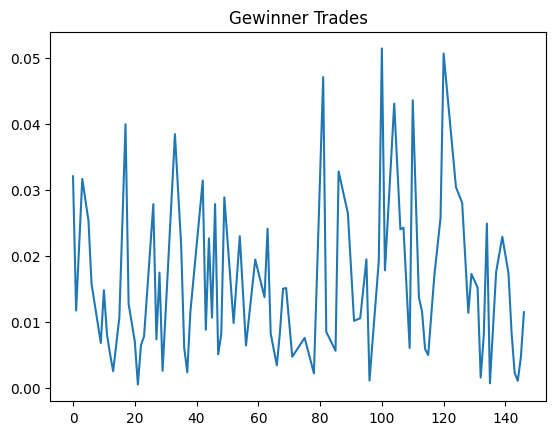

In [95]:
merged[merged.PnL > 0].ReturnPct.plot(title="Gewinner Trades")

<Axes: title={'center': 'Verlierer Trades'}>

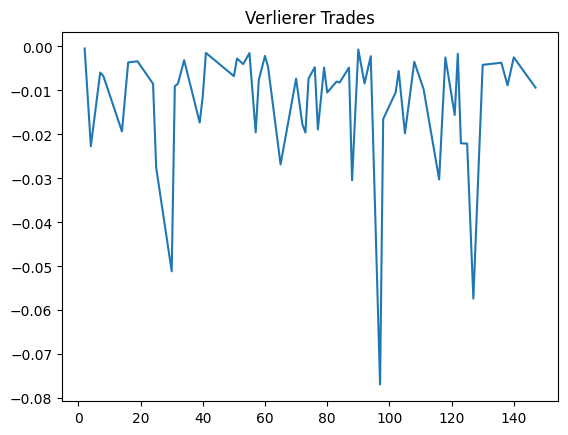

In [96]:
merged[merged.PnL < 0].ReturnPct.plot(title="Verlierer Trades")

In [97]:
class end_of_month_and_skip_month(end_of_month):
    """
    strategy for trend_trading
    """

    skip_month = []

    def next(self):
        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if self.data.days[-1] == self.days_after:
                    trade.close()

        if (
            self.data.days[-1] == self.days_before
            and self.data.month[-1] not in self.skip_month
        ):
            self.buy()

In [98]:
bt = Backtest(
    df["2012-01-01":],
    end_of_month_and_skip_month,
    cash=100_000,
    commission=0.002,
    trade_on_close=True,
)
stats = bt.run(days_before=-5, days_after=5, skip_month=skip_month)
bt.plot(superimpose=False)  # , open_browser=False)

Row(id='13778', ...)

In [99]:
stats

Start                     2012-01-02 00:00:00
End                       2024-04-15 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   31.480887
Equity Final [$]                 261598.31348
Equity Peak [$]                  261598.31348
Return [%]                         161.598313
Buy & Hold Return [%]              221.032972
Return (Ann.) [%]                    8.095572
Volatility (Ann.) [%]                9.198503
Sharpe Ratio                         0.880097
Sortino Ratio                        1.435761
Calmar Ratio                         0.586156
Max. Drawdown [%]                  -13.811283
Avg. Drawdown [%]                   -1.851484
Max. Drawdown Duration     1458 days 00:00:00
Avg. Drawdown Duration       51 days 00:00:00
# Trades                                   98
Win Rate [%]                        69.387755
Best Trade [%]                       8.823031
Worst Trade [%]                     -5.954195
Avg. Trade [%]                    

In [100]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    start_range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = start_range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)

In [101]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
1,0.2118
2,0.0579
4,0.1895
6,0.1517
7,0.0750
8,0.0494
11,0.2537
12,0.0346


In [102]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.year).PnL.sum().round(1))

,PnL
ExitTime,
2012,8676.6
2013,2548.3
2014,10192.5
2015,10945.0
2016,-13013.1
2017,2907.4
2018,-896.0
2019,13758.2
2020,39872.5


In [103]:
equity = stats["_equity_curve"]
equity.groupby(equity.index.year).Equity.last().round(1)

2012    107761.8
2013    111341.5
2014    122940.5
2015    135246.0
2016    120131.6
2017    122411.6
2018    119714.2
2019    136192.6
2020    178186.5
2021    208722.5
2022    224670.7
2023    258462.2
2024    261598.3
Name: Equity, dtype: float64